In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Cargar los datos
datos = pd.read_csv("train.csv")

def obtenerEntrenamientoPrueba(digito):
    digito_entrenamiento = digito.iloc[:int(len(digito) * 0.8), 1:].to_numpy()  # 80% entrenamiento
    digito_prueba = digito.iloc[int(len(digito) * 0.8):, 1:].to_numpy()  # 20% prueba
    return digito_entrenamiento.T, digito_prueba

# Filtrar los datos para cada dígito y dividirlos en conjuntos de entrenamiento y prueba
digitos = {}
for i in range(5):  # Considerar solo los dígitos del 0 al 4 como ejemplo
    datos_digito = datos[datos['label'] == i]
    digitos[i] = obtenerEntrenamientoPrueba(datos_digito)

# Realizar la descomposición SVD en los datos de entrenamiento de cada dígito
matrices_U = {}
for digito, (entrenamiento, _) in digitos.items():
    U, Sigma, V = np.linalg.svd(entrenamiento)
    matrices_U[digito] = U

def clasificarDigitoDesconocido(nuevoDigito, matrices_U):
    nuevoDigito = np.array(nuevoDigito).reshape(-1, 1)
    valores = []
    for digito, U in matrices_U.items():
        proyeccion = (np.identity(len(U)) - np.dot(U, U.T)) @ nuevoDigito
        valores.append(np.linalg.norm(proyeccion, ord=2) / np.linalg.norm(nuevoDigito, ord=2))
    return min(matrices_U.keys(), key=lambda digito: valores[digito])

In [2]:
# Evaluar el modelo en los conjuntos de prueba
etiquetas_verdaderas = []
etiquetas_predichas = []

for digito, (_, prueba) in digitos.items():
    for i in range(len(prueba)):
        etiquetas_verdaderas.append(digito)
        etiquetas_predichas.append(clasificarDigitoDesconocido(prueba[i], matrices_U))


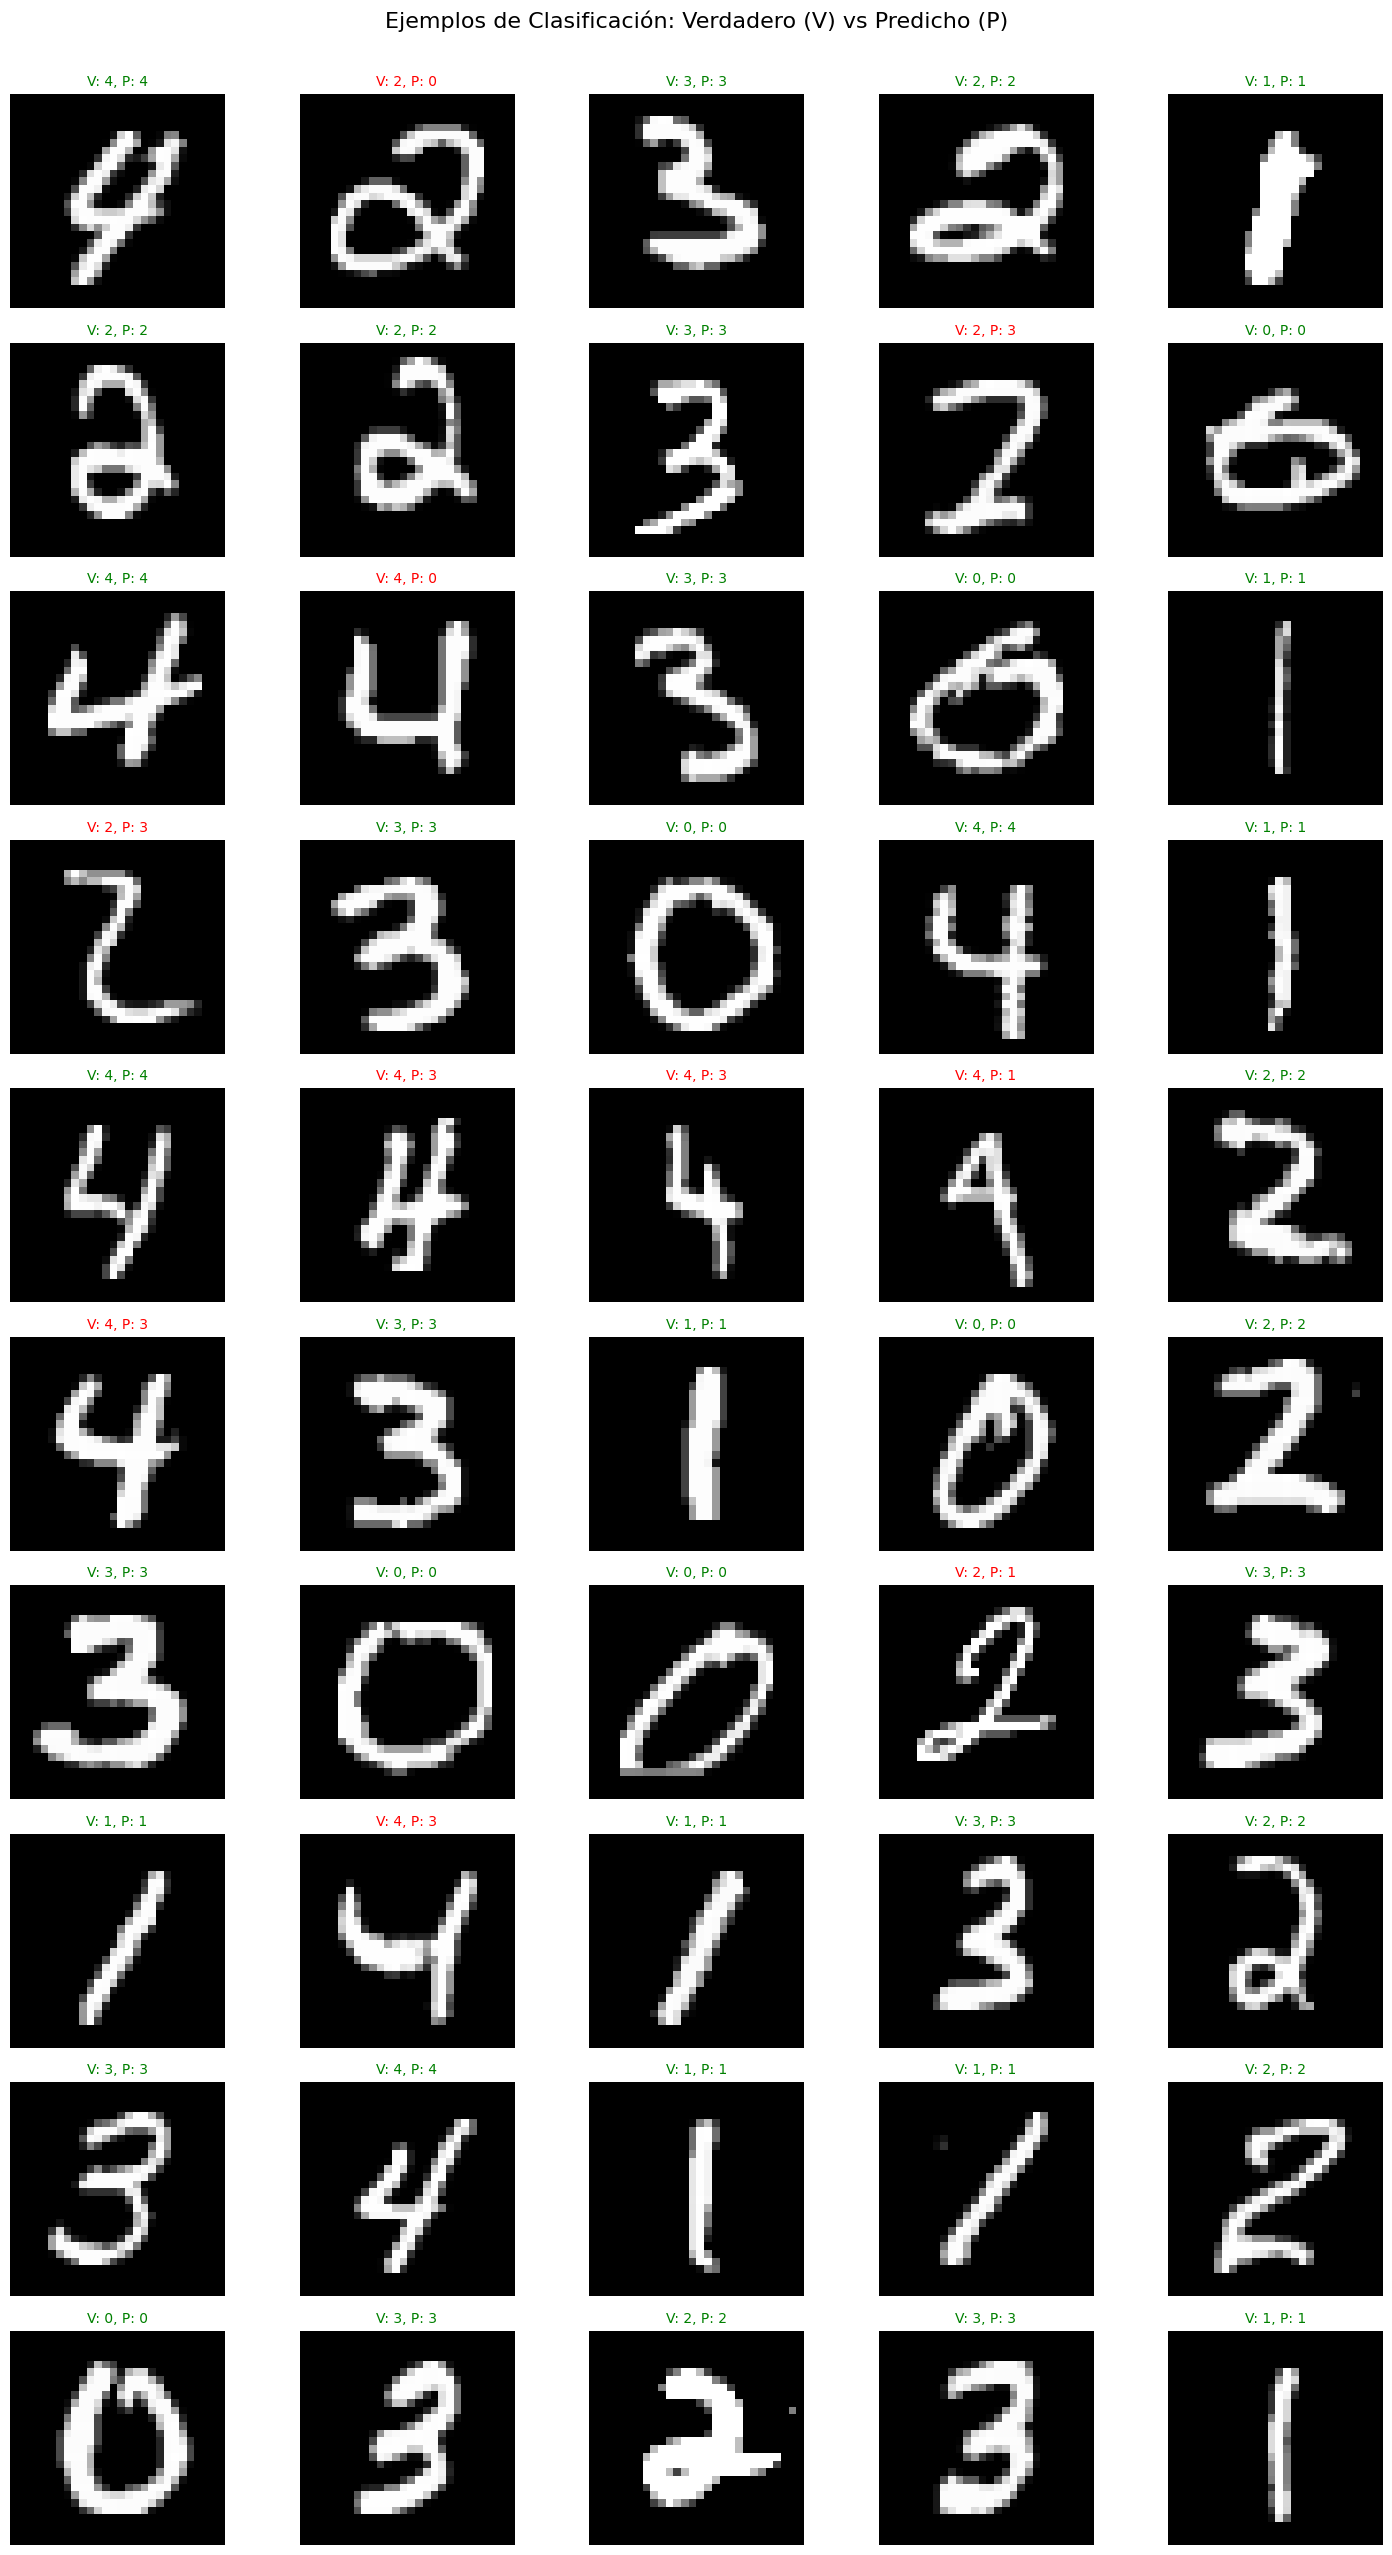

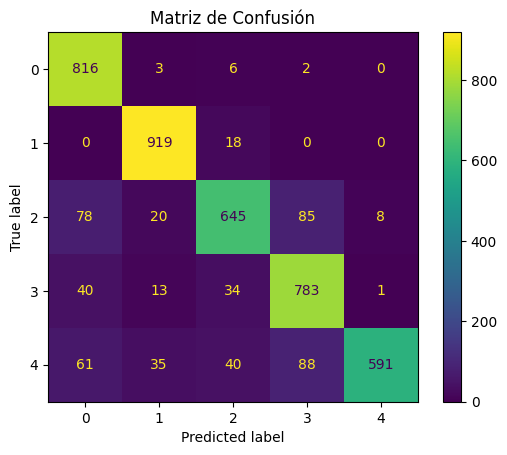

Exactitud total: 87.59%


In [3]:
# Mostrar 50 ejemplos en una sola figura con indicador de corrección
fig, ejes = plt.subplots(10, 5, figsize=(15, 25))  # Crear una cuadrícula de 10x5 subplots

ejemplos = 50  # Número de ejemplos a mostrar
for i in range(ejemplos):
    # Seleccionar un dígito al azar
    digito = np.random.choice(list(digitos.keys()))

    # Seleccionar un índice aleatorio del conjunto de prueba de ese dígito
    idx = np.random.randint(0, digitos[digito][1].shape[0])

    # Obtener la imagen de prueba y sus etiquetas
    imagen_prueba = digitos[digito][1][idx]
    etiqueta_verdadera = digito
    etiqueta_predicha = clasificarDigitoDesconocido(imagen_prueba, matrices_U)

    # Determinar si la predicción es correcta
    es_correcto = (etiqueta_verdadera == etiqueta_predicha)
    color = "green" if es_correcto else "red"

    # Ubicar la imagen en el subplot correspondiente
    ax = ejes[i // 5, i % 5]
    ax.imshow(imagen_prueba.reshape(28, 28), cmap="gray")
    ax.set_title(f"V: {etiqueta_verdadera}, P: {etiqueta_predicha}", color=color, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.suptitle("Ejemplos de Clasificación: Verdadero (V) vs Predicho (P)", fontsize=16, y=1.02)
plt.show()

# Matriz de confusión
matriz_confusion = confusion_matrix(etiquetas_verdaderas, etiquetas_predichas)
disp = ConfusionMatrixDisplay(matriz_confusion, display_labels=range(5))
disp.plot(cmap="viridis")
plt.title("Matriz de Confusión")
plt.show()

# Calcular y mostrar la exactitud total
exactitud = np.mean(np.array(etiquetas_verdaderas) == np.array(etiquetas_predichas))
print(f"Exactitud total: {exactitud:.2%}")